# SparK: A Visualization Demo
A demo using our pre-trained SparK model (ConvNeXt-L with input size 384) to reconstruct masked images.
The mask is whether specified by the user or randomly generated.

## 1. Preparation
Install dependencies and specify the device.

In [1]:
# install dependencies
import sys
if 'google.colab' in sys.modules:
    !pip3 install -r requirements.txt

# specify the device to use
USING_GPU_IF_AVAILABLE = True
import torch
_ = torch.empty(1)
if torch.cuda.is_available() and USING_GPU_IF_AVAILABLE:
    _ = _.cuda()
DEVICE = _.device
print(f'[DEVICE={DEVICE}]')


[DEVICE=cuda:0]


## 2. Define utils: load data

In [2]:
from PIL import Image
import torchvision.transforms as T
IMAGENET_DEFAULT_MEAN = (0.485, 0.456, 0.406)
IMAGENET_DEFAULT_STD = (0.229, 0.224, 0.225)
def load_image(img_file: str):
    img = Image.open(img_file).convert('RGB')
    transform = T.Compose([
        T.Resize((384, 384)),
        T.ToTensor(),
        T.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
    ])
    img = transform(img)
    return img.unsqueeze(0).to(DEVICE)

## 3. Define utils: build a SparK model

In [3]:
import os
from decoder import LightDecoder
from encoder import SparseEncoder
from models import build_sparse_encoder
from spark import SparK
def build_spark():
    # download and load the checkpoint
    ckpt_file = 'cnxL384_withdecoder_1kpretrained_spark_style.pth'
    ckpt_link = 'https://drive.google.com/file/d/1ZI9Jgtb3fKWE_vDFEly29w-1FWZSNwa0/view?usp=share_link'
    assert os.path.exists(ckpt_file), f'please download checkpoint {ckpt_file} from {ckpt_link}'
    pretrained_state = torch.load(ckpt_file, map_location='cpu')
    
    # build a SparK model
    enc: SparseEncoder = build_sparse_encoder('convnext_large', input_size=384)
    spark = SparK(
        sparse_encoder=enc, dense_decoder=LightDecoder(enc.downsample_raito, sbn=False),
        mask_ratio=0.6, densify_norm='ln', sbn=False, hierarchy=4,
    ).to(DEVICE)
    spark.eval(), [p.requires_grad_(False) for p in spark.parameters()]
    
    # load the checkpoint
    missing, unexpected = spark.load_state_dict(pretrained_state, strict=False)
    assert len(missing) == 0, f'load_state_dict missing keys: {missing}'
    assert len(unexpected) == 0, f'load_state_dict unexpected keys: {unexpected}'
    del pretrained_state
    return spark


## 4. Define utils: visualize

In [4]:
import matplotlib.pyplot as plt
def show(spark: SparK, img_file='viz_imgs/recon.png', active_b1ff: torch.BoolTensor = None):
    inp_bchw = load_image(img_file)
    spark.forward
    inp_bchw, masked_bchw, rec_or_inp = spark(inp_bchw, active_b1ff=active_b1ff, vis=True)
    # plot these three images in a row
    masked_title = 'rand masked' if active_b1ff is None else 'specified masked'
    for col, (title, tensor) in enumerate(zip(['input', masked_title, 'reconstructed'], [inp_bchw, masked_bchw, rec_or_inp])):
        plt.subplot2grid((1, 3), (0, col))
        plt.imshow(tensor[0].permute(1, 2, 0).cpu().numpy())
        plt.title(title)
        plt.axis('off')
    plt.show()

## 5. Run SparK with a specified mask

In [5]:
spark = build_spark()

[build_sparse_encoder] model kwargs={'sparse': True, 'drop_path_rate': 0.4, 'pretrained': False, 'num_classes': 0, 'global_pool': ''}
[SparK.__init__, densify 1/4]: densify_proj(ksz=1, #para=1.18M)
[SparK.__init__, densify 2/4]: densify_proj(ksz=3, #para=2.65M)
[SparK.__init__, densify 3/4]: densify_proj(ksz=3, #para=0.66M)
[SparK.__init__, densify 4/4]: densify_proj(ksz=3, #para=0.17M)
[SparK.__init__] dims of mask_tokens=(1536, 768, 384, 192)


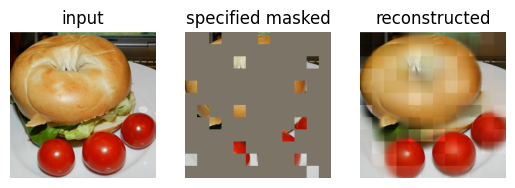

In [6]:
# specify the mask
show(spark, 'viz_imgs/recon.png', active_b1ff=torch.tensor([
    [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
], device=DEVICE).bool().unsqueeze(0).unsqueeze(0))

## 6. Run SparK with a random mask

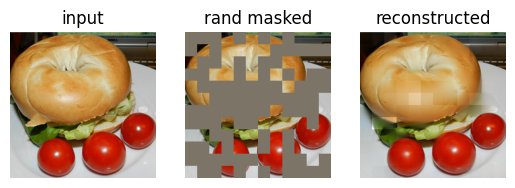

In [7]:
show(spark, 'viz_imgs/recon.png', active_b1ff=None)